In [1]:
import sys, os
import cmath
import numpy             as np
import numpy.linalg      as lin
import scipy             as sp
import scipy.integrate   as integ
import matplotlib.pyplot as plt

path_PythonCodeSet = "/Users/miiya/python_code-set/lib"
sys.path.append(path_PythonCodeSet)

import common.statistics
import fitting.fitfunc_type
import fitting.io_params
import sch_diffeq.solve_diffeq
import Tmatrix.convert_mat
import Tmatrix.calc_phase_shift

hbar_c = 197.327053

In [77]:
ibase  = "/Users/miiya/Dropbox/work/paper/Lambda_c-N/data/params"
ifname = "params.ens3.spin0.t09"

In [78]:
Nch   = 1

mass1 = 1581
mass2 = 2685

mu = (mass1*mass2)/(mass1+mass2)

TmpFuncName, TmpParams = fitting.io_params.input_params(ibase+"/"+ifname)
FuncName = np.array([[TmpFuncName ]])
Params   = np.array([[TmpParams   ]])
mass     = np.array([[mass1, mass2]])

fit_funcs = np.array([[fitting.fitfunc_type.set_fitfunc_from_fname(FuncName[ich][jch]) 
                       for jch in range(Nch)] for ich in range(Nch)])

# Successful to input fit parameters.
# N.conf    = 10
# N.param   = 7
# func_name = 2G1Ysq


In [79]:
# [MeV]
kmin   = 1e-6
kdel   = 1
kmax   = 100.0

N_k   = int((kmax - kmin) / kdel)
kdata = np.array([kmin + i*kdel for i in range(N_k)])

Edata = kdata**2 / (2.0*mu)
N_E   = len(Edata)

In [80]:
Rmax   = 6.0

Nconf  = len(Params[0,0,:,0])
Nparam = len(Params[0,0,0,:])
Tmat   = np.empty((Nconf, N_E, Nch, Nch), dtype=complex)
print("#\n# Calculate T-matrix...")
for iconf in range(Nconf):
    tmpParams = np.array([[[Params[ich,jch,iconf,iparam] for iparam in range(Nparam)] for jch in range(Nch)] for ich in range(Nch)])
    Tmat[iconf,:,:,:] = sch_diffeq.solve_diffeq.solve_sch_diff(np.array([[0.0,1.0]]), fit_funcs, tmpParams, mass, Edata, np.array([0]), 1e-10, Rmax)
    print("# Calculate T-matrix... end: iconf=%03d" % iconf)
Smat = Tmatrix.convert_mat.convert_TtoS(Tmat)[:,:,0,0]

#
# Calculate T-matrix...
# Calculate T-matrix... end: iconf=000
# Calculate T-matrix... end: iconf=001
# Calculate T-matrix... end: iconf=002
# Calculate T-matrix... end: iconf=003
# Calculate T-matrix... end: iconf=004
# Calculate T-matrix... end: iconf=005
# Calculate T-matrix... end: iconf=006
# Calculate T-matrix... end: iconf=007
# Calculate T-matrix... end: iconf=008
# Calculate T-matrix... end: iconf=009


0.664650951798 5.00412381952


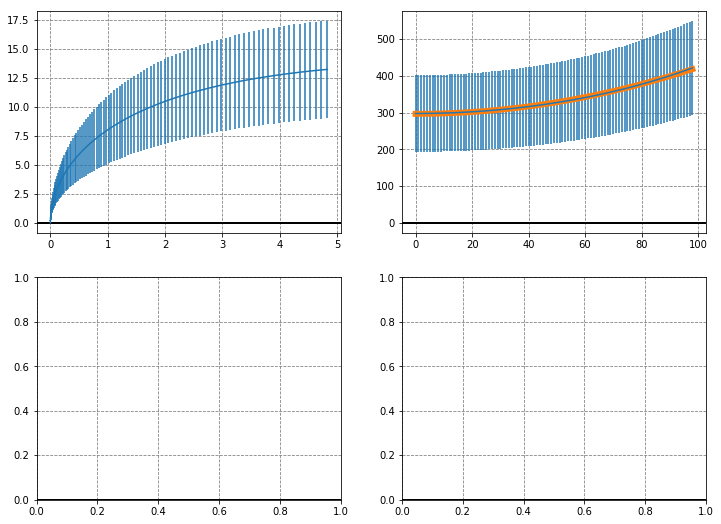

In [81]:
from scipy.optimize import curve_fit
psh   = np.array([Tmatrix.calc_phase_shift.calc_phase_Sii(Smat[iconf,:])[0] for iconf in range(Nconf)])
kcotd = kdata / np.tan(psh * np.pi/180.0)
fit_f = lambda k,a,r: a+r*k**2/2.0
oprm  = curve_fit(fit_f, kdata, np.mean(kcotd, axis=0),
                  sigma=np.std(kcotd, axis=0)*np.sqrt(Nconf-1), p0=(1.0,1.0))[0]
a = hbar_c/oprm[0]
r = hbar_c*oprm[1]
fig, axe = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

print(a,r)

axe[0,0].errorbar(Edata, np.mean(psh  , axis=0), yerr=np.std(psh  , axis=0)*np.sqrt(Nconf-1))
axe[0,1].errorbar(kdata, np.mean(kcotd, axis=0), yerr=np.std(kcotd, axis=0)*np.sqrt(Nconf-1))
axe[0,1].plot(kdata, fit_f(kdata, hbar_c/a, r/hbar_c), lw=6)
for i in range(2):
    for j in range(2):
        axe[i,j].grid(which='major',color='gray',linestyle='--')
        axe[i,j].axhline(0.0, lw=2, color='black')